# Statistical Analysis of ERP Data

Having seen how we combine and visualize the results of an ERP experiment in the previous lesson, we will now turn to the statistical analysis of ERP data. There are a number of approaches to performing statistical tests on ERPs. As noted in the previous lesson, we can infer a significant difference between conditions from the 95% CIs around the difference waveform plot. However, typically for a scientific publication we want to report detailed statistics, such as $t$ and $p$ values. As well, we might want to consider all of the channels individually, or in clusters, rather than just one or a few channels as shown in the plot above.

A conventional approach to ERP statistics is to measure the amplitude of each component of interest, averaged over a time window. For instance, we could compute the mean amplitude of the N400 at each channel from 300--500 ms. Then we could use these values in a statistical test such as a $t$ test, ANOVA, or linear mixed effects model.

The spatio-temporal nature of EEG data presents some challenges however. If we compute a mean amplitude over a time window as described above, then we have "collapsed" over time so we don't need to worry about that dimension. However, in the present data we have 64 channels so we need to worry about how the ERP differences vary over space. One approach would be to define a *region of interest* (ROI) and average over the channels in that ROI. This is what we did to plot the waveforms above. We could also define a number of ROIs (e.g., dividing the scalp into a 3 x 3 grid), if we wanted to test for differences across the scalp. 

A challenge with picking time windows and ROIs in advance, however, is how to pick these in a way that accurately captures the time and scalp distribution of the ERP effects of interest. Defining an ROI(s) runs the risk that a component's scalp distribution might only partly overlap a particular ROIs. Typically all statistical analysis choices should be made a priori (before looking at your data), so we can't just look at the data and decide which channels to include in each ROI. Selecting a subset of data points to use in statistical analysis, based on looking at the data, is poor practice because it artificially inflates the likelihood of finding a significant result. When we apply statistics (at least in conventional approaches), we are testing hypotheses. Hypotheses are predictions about the outcome of the experiment that you should make before conducting the experiment. If you look at the data and then decide which channels to include in your ROI, you are effectively making a prediction about the data after you have seen it, which is not a valid test of your hypothesis. This is a form of **HARKing** (Hypothesizing After the Results are Known), which is a form of **p-hacking** (trying different analyses until you find one that produces a significant result). HARKing and p-hacking were discussed in the [Introduction](../1-intro/novelty.md). An excellent paper on this topic is [Luck and Gaspelin (2017)](https://doi.org/10.1111/psyp.12639), *How to get statistically significant effects in any ERP experiment (and why you shouldn't)*.

On the other hand, in most ERP experiments the hypotheses center around components that have been characterized in previous studies, so we can often make pretty accurate predictions as to which time windows and ROIs will be most relevant. For instance, in the present case we predicted an N400, which we knew from previous studies with similar stimuli would likely be largest between 300-500 ms at channels centered around Cz and Pz. So we could perform our statistical test on this combination of time and channels. However, there is a chance that we miss a true effect, if the timing or scalp distribution is not as predicted, or if there is a difference that we did not predict. For these reasons, it's good to also consider *data-driven* statistical approaches. We will explore each of these in turn.

## Load packages

In [1]:
import mne
# a couple of specific functions we'll use
from mne.channels import find_ch_adjacency, make_1020_channel_selections
mne.set_log_level('error')  # reduce extraneous MNE output
import matplotlib.pyplot as plt
import numpy as np
import glob

## Define parameters

We define a list of experimental conditions; that's about the only parameter we need to define here.

In [2]:
conditions = ['Control', 'Violation']

## Load Data

We'll load all the `-ave.fif` files (`Evoked` data sets) that we visualized in the previous lesson, and compute the difference waves.

In [3]:
data_dir = 'data/group_data/'
data_files = glob.glob(data_dir + 'sentence_n400_p*-ave.fif')

evokeds = {}
for idx, c in enumerate(conditions):
    evokeds[c] = [mne.read_evokeds(d)[idx].set_montage('easycap-M1') for d in data_files]
 
diff_waves = [mne.combine_evoked([evokeds['Violation'][subj], 
                                evokeds['Control'][subj]
                                ],
                                weights=[1, -1]
                                ) 
            for subj in range(len(data_files))
            ]

As a refresher, let's plot the topo map over the N400 time window, for the difference waves averaged across participants.

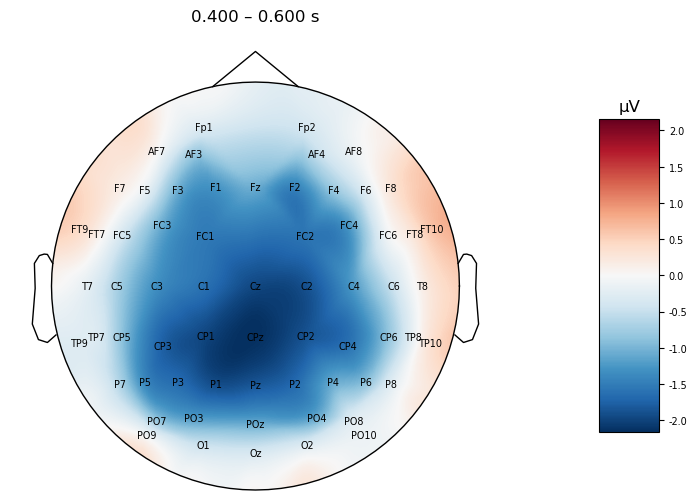

In [4]:
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves), 
                            times=.500, average=0.200, 
                            show_names=True, sensors=False,
                            contours=False,
                            size=4
                           );

## A priori $t$ test
A common approach to testing whether an ERP effect is significant is to perform a $t$ test between a pair of conditions, on the ERP data averaged over a time period of interest and at one or a few electrodes. Ideally, the experimenter should have an *a priori* (i.e., defined prior to running the experiment) hypothesis regarding the time window and electrodes at which the ERP component and experimental effect of interest would be largest. In the present case, we predicted an N400, which we knew from previous studies with similar stimuli would likely be largest between 400–600 ms, at midline channels Cz, CPz, and Pz. 

In this case, we will use the `ttest_1samp()` function from SciPy's `stats` module. This tests whether a set of values are different from zero. So we use as input the *Violation-Control* differences for each participant (`diff_waves`), since if they are significantly different from zero, that will be evidence for a difference in amplitude between these two conditions. 

We first compute the average over the 400–600 ms time window, for each participant, at the channels of interest, and store these in a NumPy array on which we then perform the $t$ test. The rows in the array correspond to participants, and the columns to channels. The code below is a bit complex so take the time to really unpack and understand it:
- we define the time window and channels of interest as variables, for readability and easy modification later. We use tuples to indicate that we would not want these values changed after they're defined.
- The operation below embeds a list comprehension inside an `np.array()` function. This is a convenient way to create a NumPy array from a list of values. Inside the list comprehension, we loop over the items in the list `diff_waves`, where each entry is the violation–control difference wave for one of the participants. The data itself is extracted from the `Evoked` object using the `.get_data()` method, with some kwargs:
   - we use the `picks` kwarg to specify which electrode(s) we want. Here we pass the `roi` tuple.
   - we use the `tmin` and `tmax` kwargs to specify the time range over which we want to extract the ERP data. This is the tuple `time_win`. 
- The result of `.get_data()` will be a NumPy array with the shape of number of channels X number of time points. 
- We apply `np.mean()` with the `axis=1` kwarg to the result of `.get_data()`, to average across the 400-600 ms time window. `axis=1` kwarg instructs the function to average over columns (axis 1; time) and not rows (axis 0; electrodes).
- The result of this is an np array with one row and three columns: the mean amplitude values at each channel in the ROI.
- These arrays for each participant are stored in a list that is passed to `np.array()`, which converts it to an array with 26 rows (participants) and 3 columns (channels).


In [5]:
time_win = (.400, .600)
roi = ('Cz', 'CPz', 'Pz')

y = np.array([np.mean(e.get_data(picks=roi, 
                                 tmin=time_win[0], 
                                 tmax=time_win[1]
                                 ),
                      axis=1) 
              for e in diff_waves
              ]
             )

# check shape of result
y.shape

(26, 3)

Now we perform the $t$-test. Note that `ttest_1samp()` produces NumPy arrays for its outputs (which here we assign to `t` and `pval`), even when we only performed one $t$-test. So when we print the results on the last line, we need to use `t[0]` and `p[0]` rather than simply `t` and `p`.

In [6]:
from scipy import stats 

t, pval = stats.ttest_1samp(y, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Difference t =  -3.23 p =  0.0035


The $p$ values is < .05 so we can reject the null hypothesis of no difference between the conditions, and conclude that the difference between conditions is statistically significant.

## Mass Univariate Analyses

The $t$ test on the ROI was significant, consistent with a difference in N400 amplitude between violation and control conditions. However, this does not give us an estimate of the true spatial extent of the effect, or whether there are other channels and/or time points that show a significant difference between conditions. For instance, we could perform a $t$ test over the N400 time window at every channel, rather than averaged over only 3 channels (in which case, what is the use of collecting data from 64 channels?). Performing a statistical test at every channel and time point is called a **mass univariate analysis**. The name refers to the fact that $t$-tests are a type of statistical test called univariate, meaning that the test centers on a single outcome value (in this case, ERP amplitude). The "mass" part refers to the fact that we are performing a large number of univariate tests, because we are testing the difference between conditions at every channel and time point. Thus rather than performing a single $t$-test averaged over an ROI as we did above, in the present data set if we tested at every channel and time point we would be performing 64 (channels) * 615 (time points) = 39,360 $t$-tests.


### The Problem of Multiple Comparisons

Performing so many independent $t$-tests ("independent" meaning that the outcome of one test does depend on outcome of any other test) increases our chances of finding a significant result by chance. Statistical significance is typically determined based on a $p$ value, which is the probability of finding a result as or more extreme than the one we found, if the null hypothesis were true (i.e., if there was no real difference between conditions). In other words, if we find a $p$ value of .05, this means the probability of finding this result by chance is 1 / 100, or 5%. Thus if we perform 39,360 independent $t$-tests, and we use a threshold for significance (alpha, or $\alpha$) of $p$ < .05, then we can expect to find 1,968 significant results by chance (39,360 * .05 = 1,968). In other words, we are likely to find nearly 2,000 time point/channel combinations that show a "significant" difference between conditions, even if there is no real difference between conditions. This is called the **problem of multiple comparisons**. 

There are a number of ways to address the problem of multiple comparisons. One is to simply use a more stringent threshold for significance. For instance, we could use $p$ < .01, which would mean we would expect to find only 394 significant results by chance (39,360 * .01 = 394). However, this is a bit arbitrary, and it doesn't address the fact that we are performing a large number of tests.

Another way to correct for multiple comparisons is the **Bonferroni** method, which involves simply dividing the desired $\alpha$ value for the experiment (i.e., across all tests) by the number of tests. For this data set that would mean $.05 / 64 * 615 = .000001$. This is a very stringent threshold, and would likely result in no significant results. However, the Bonferroni method is actually inappropriate for ERP data. It assumes that each statistical test is statistically independent of the others, which is not true for multiple channels of EEG data — nearby channels can be predicted to have similar values, since they are measuring activity from nearby scalp locations. There are, however, other multiple comparisons correction methods that are appropriate for EEG data, such as the **cluster-based permutation test**.


## Permutation $t$ Test for Multiple Comparison Correction

 One popular multiple comparison correciton method for EEG data is a **permutation** $t$ test. Widely introduced to the field of neuroimaging by [Nichols and Holmes (2001)](https://doi.org/10.1002/hbm.1058), permutation is a well-established approach in the field of statistics. The basic concepts in permutation testing are *exchangability* and *randomization*. If we have multiple data points from two sets of experimental conditions (e.g., *Violation* and *Control*), and there is no true difference between the conditions, then it should not matter if we perform a $t$ test between the data points using the correct condition labels, or if we randomly re-label the condition of each data point (i.e., *exchange* the labels among data points). In other words, if ERP amplitude in the *Violation* and *Control* conditions are not truly different, then if we scramble which data points we call *Violation* and which ones we call *Control*, and perform the $t$ test again, the results of that $t$ test should not be too different from the $t$ test based on the correct labels. 
 
 On the other hand, if there is a true experimental effect, then randomizing the labels of each data point should result in consistently lower $t$ values than the true labeling. The reason this approach is called *permutation* testing is that we perform the random exchange of labels and data points many times, each with a different reassignment (i.e., a different permutation of labels and data points). Typically this is done thousands of times, in order to get a reliable estimate of the *null distribution* — that is, the distribution of $t$ scores across different permutations that we know don't match the true label-to-data-point mapping. 

This approach doesn't in and of itself correct for multiple comparisons. However, when permutation tests are performed over a number of different sets of data (such as a separate $t$ test on the data from each individual electrode), can can use this to correct for multiple comparisons. This is called the **maximal statistic** method. It is based on the recognition that the distribution of $t$ (and associated $p$) values across thousands of random permutations of labels actually reflects the "chance" that our use $p$ values are based on. In other words, in conventional $t$ tests if we use an $\alpha$ of .05, then we are saying that we accept a 5% chance that over many replications of the experiment we would get a "significant" result by chance. Since our permutation distribution actually *is* thousands of replications of an "experiment" in which there is no true effect, we can say that the top 5% of the $t$ values we obtain from the permutations are what we consider "significant". We can provide even better control for multiple comparisons by looking at the maximum $t$ values not just at each electrode separately, but across all the electrodes. We can set the critical $t$ value (i.e., the $t$ threshold for significance) to be $(\alpha * N) + 1$, where $N$ is the number of electrodes. That is, our $t$ threshold is set so that just under 5% of the randomly-obtained $t$ values are greater than this threshold. 

### Clustering

An additional multiple comparison correction that can be applied is **clustering**. This is based on the recognition that the ERP is a spatio-temporal signal, and that any real ERP effect of interest is likely to be present not at a single channel and time point, but at a cluster of nearby channels and time points. For instance, the N400 is typically largest at midline channels Cz, CPz, and Pz, but it is also present at nearby channels such as FCz and C1. Likewise, it is typically largest between 400–600 ms, but it is also present at nearby time points such as 350 and 650 ms.

The clustering approach involves first performing a $t$ test at every channel and time point, over many permutations, as described above. But then we threshold the resulting set of $t$ values (in this case the $t$ value that corresponds to $p < .05$) and find clusters — cases where adjacent channels and/or time points also have above-threshold $t$ values (and with the same sign, meaning that we don't cluster positive potential differences with negative potential differences). Then, just as we built the null distribution of $t$ values across permutations, we can build a null distribution of the size of the largest cluster in each permutation. We can use that to determine the $p$ value for each cluster in the $t$ test with the correct labels, based on the proportion of permutations that have a cluster of that size or larger.

#### Prepare the Data for Mass Univariate Analysis

MNE provides a `spatio_temporal_cluster_1samp_test()` function which we import here. 

In [7]:
from mne.stats import spatio_temporal_cluster_1samp_test

The `spatio_temporal_cluster_1samp_test()` function only allows for a 1-sample test, so — similar to the single-electrode $t$ test above — we will run this on the *Violation-Control* differences for each participant. So we then create a NumPy array of data from the difference waves of each of our participants. The command here is simpler than for the previous example, because don't use `picks` to select a channel, nor to we want to select only certain time points and average over them. We want to extract the data from all channels and time points. So we simply use `.get_data()` to extract the data from each `Evoked` object, and then use `np.array()` to convert the list of arrays into a single NumPy array.

The [`spatio_temporal_cluster_1samp_test()`](https://mne.tools/stable/generated/mne.stats.spatio_temporal_cluster_1samp_test.html#mne.stats.spatio_temporal_cluster_1samp_test) function  actually requires the data to be shaped as $participants \times time \times channels$ — but our data are $participants \times channels \times time$ — so we will use `np.swapaxes()` to swap the time `[1]` and channel `[2]` axes:

In [8]:
y = np.swapaxes(np.array([e.get_data() 
                          for e in diff_waves
                          ]
                         ),
                1, 2
                )

# check shape of result
y.shape

(26, 615, 64)

#### Create Adjacency Matrix

The last thing we need to do is to create an adjacency matrix. This is a matrix that specifies which channels are adjacent to each other on the scalp. This is used in the clustering step. We can visualize these in a plot with lines connecting adjacent channels:

In [9]:
adjacency, ch_names = find_ch_adjacency(diff_waves[0].info, ch_type='eeg')
mne.viz.plot_ch_adjacency(diff_waves[0].info, adjacency, ch_names=ch_names);

### Run the Spatial-Temporal Permutation Cluster Test

Now we run the test. We set an `n_perm` variable that controls the number of permutations (random samples) of the data that will be used to estimate the null distribution. We set this to 50,000, which can take a long time to run. But in order for the results to be reliable (i.e., likely to get the same or very similar results with another sample of random permutations), we need to run lots of permutations. By default (which we won't change), the function uses an $\alpha$ of .05, and uses the maximal statistic method to correct for multiple comparisons.

Note the formatting of the code here: because we have 4 output variables and a long function name, we wrap all the lines so that they are only indented one level rather than all the way out where the function name is. This makes it easier to read the code.

In [18]:
n_perm = 5e4

t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test( 
    y, 
    adjacency=adjacency,
    n_permutations=n_perm, 
    out_type='mask',
    n_jobs=-1, 
    verbose='Info'
    )

Using a threshold of 2.059539
stat_fun(H1): min=-5.136169 max=5.136169
Running initial clustering …
Found 58 clusters


  0%|          | Permuting : 0/49999 [00:00<?,       ?it/s]

We used the `verbose='Info'` kwarg to see some information about the results of the clustering, as well as a progress bar. The output indicates we ended up with 56 clusters. That's a lot of clusters to look at, so we'll combine them into one array that we can use to visualize which channels and time points were significant across all the clusters.

One of the kwargs we specified above was `out_type='mask'`, which overrides the default format. The `mask` format creates a set of NumPy arrays, one for each cluster. Each array the same shape as the data, but with 1s where the data are significant, and 0s where they are not. We can use this to plot the significant clusters in various ways by *masking* the data. That is, we show the data only at significant channels and time points, and hide it everywhere else.

In [11]:
# find significant points across all clusters
mask_idx = np.where(cluster_pv < 0.05)[0]
mask = [clusters[idx] for idx in mask_idx]

# stats output is time X chan, but ERP data is chan X time, so transpose
mask = mask[0].T

### Visualize the Results

Now we can view the results on a **raster plot**, where the rows are channels and the columns are time. MNE's `make_1020_channel_selections()` function is used to break the channels into groups of left, midline, and right channels, which are plotted as three separate rasters. We use the mask to only show the microVolt values of the Violation–Control difference at significant channels/time points. Thus non-significant areas are grey, and the blue areas indicate where the difference between conditions is significantly different from zero, in th negative direction (Violation–Control). There are no red areas, indicating that there are no significant differences in the positive direction (Control–Violation).

The pattern is consistent with the predicted N400, in showing a large proportion of midline channels as significant, along with left and right channels mostly close to Cz and Pz.

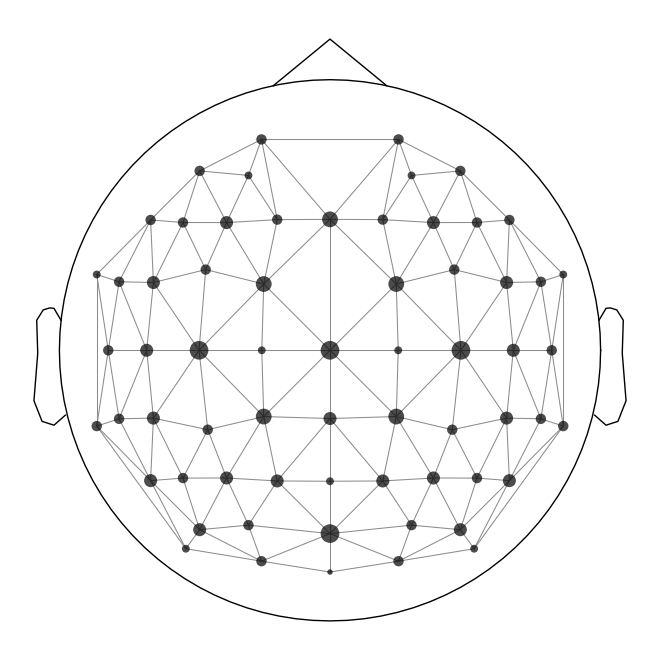

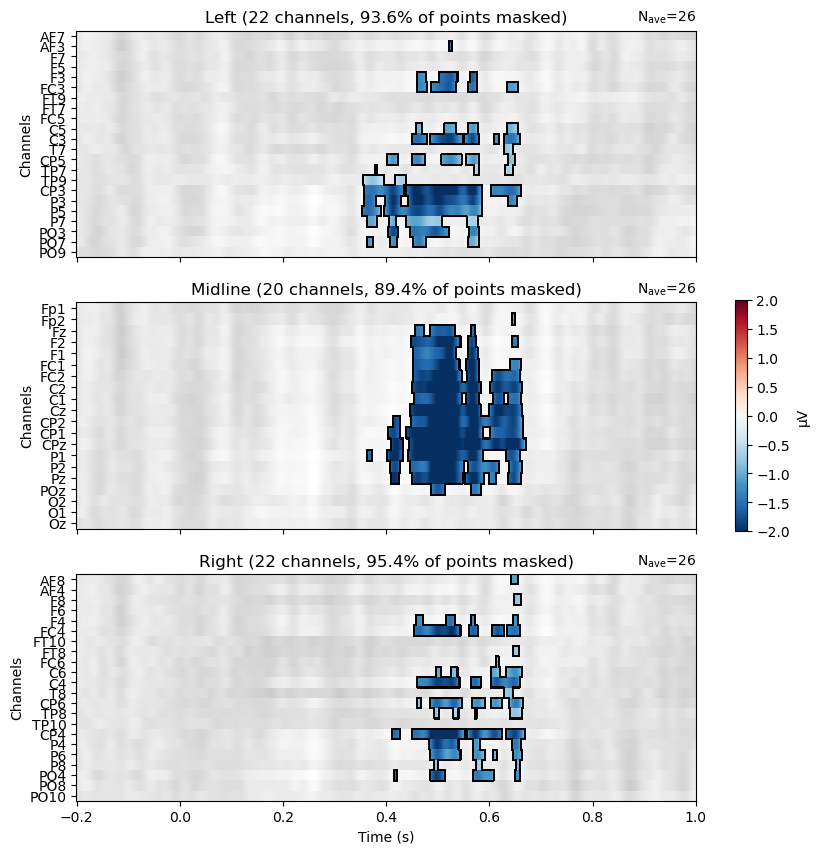

In [12]:
from mne.channels import find_ch_adjacency, make_1020_channel_selections

# Create ROIs by checking channel labels
selections = make_1020_channel_selections(diff_waves[0].info, midline="12z")
time_unit = dict(time_unit="s")

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
mne.grand_average(diff_waves).plot_image(axes=axes,
                            group_by=selections,
                            colorbar=False,
                            show=False,
                            mask=mask,
                            show_names="all",
                            titles=None,
                            **time_unit,
                            clim = dict(eeg=[-2, 2])
                            )
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()

### Plot Topomap of N400 time window

All of the clusters seem to fall roughly in the 400–600 ms time window we expected, although the effect seems to start a bit later than 400 ms and extend until about 650 ms. It's also present across a much larger number of channels than just the three in our ROI above. This demonstrates the value of a data-driven approach in characterizing the actual effects in your data, without being constrained by too-narrow hypotheses.

We can visualize the effect across the scalp more easily them by plotting a topographic map of the group mean difference wave, with the data masked to only show the significant channels. 

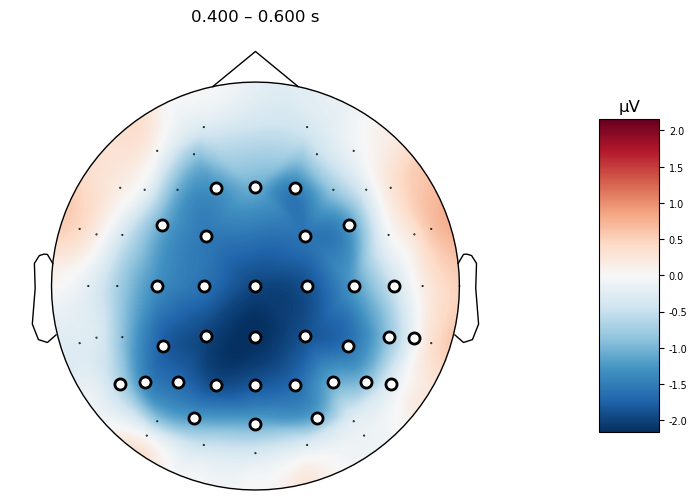

In [13]:
mne.grand_average(diff_waves).plot_topomap(times=.500,
                                             average=0.200,
                                             mask=mask,
                                             contours=False,
                                             sensors=True,
                                             size=4
                                            );

## Threshold-Free Cluster Enhancement

The permutation cluster $t$ test is a powerful approach to correcting for multiple comparisons, while allowing the data to "speak for itself" rather than being constrained by a priori hypotheses. This can be useful for exploratory analyses, or for cases where the researcher has a priori hypotheses but wishes to characterize the spatial and temporal extent of an effect in the data rather than simply testing a hypothesis at a subset of time points and channels. However, the clustering approach we used above has limitations. For one, it is based on arbitrary thresholds. In order to form the clusters above, we set a $p < .05$ threshold to determine which channels and time points were "significant", and then formed clusters from these. This threshold is conventional, but arbitrary, and the results will depend on the data itself. The more statistical power we have (which comes from the number of trials and participants), the more likely we are to find significant results at each channel/time point. So we cannot necessarily treat the results as indicating the true boundaries of which time points and channels show a difference. 

An alternative approach to determining statistical significance in cluster-based permutation testing is **threshold-free cluster enhancement** (TFCE; [Smith & Nichols, 2009](https://dx/doi.org/doi:10.1016/j.neuroimage.2008.03.061)). As the name implies, this method does not rely on an arbitrary threshold to determine which channels and time points are significant. Instead, it takes the statistical image (the set of $t$ values across all channels and time points) and applies a mathematical transformation, which is designed to enhance clusters of nearby channels and time points. The transformation is based on the assumption that significant ERP activity will be distributed over multiple channels and time points. Therefore it computes a "score" at each channel/time point which reflects the weighted sum of values from nearby channels and time points. This serves to "enhance" (increase) the statistical values at channels and time points when there is "support" for this from similar, surrounding values. In contrast, a channel/time point that has a high value but does not have support from surrounding channels/time points will have a low score, because this is more likely to be a spurious result.

To implement TFCE we again use the `mne.stats.permutation_cluster_1samp_test()` function, but we define the `threshold` kwarg using a dictionary with `start` and `step` parameters. This instructs the function to use TFCE. Because this stepwise process takes longer, we reduce the number of permutations by a factor of 10 to speed things up. To make reliable inferences, e.g., for a publication, we should stick with 50,000 permutations but for demonstration purposes we will use fewer here.

In [15]:
n_perm = 5e3
threshold_tfce = dict(start=0, step=0.2)

t_tfce, clusters_tfce, cluster_pv_tfce, H0_tfce = spatio_temporal_cluster_1samp_test( 
    y, 
    threshold=threshold_tfce,
    adjacency=adjacency,
    n_permutations=n_perm, 
    out_type='mask',
    n_jobs=-1, 
    verbose='Info'
    )

stat_fun(H1): min=-5.136169 max=5.136169
Running initial clustering …
Using 26 thresholds from 0.00 to 5.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 39360 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

We can plot the results of the TFCE permutation test in the same way as we did for the clustering approach above. The results are very similar, but the TFCE approach results in a more conservative estimate of the extent of the effect — we see significance at fewer channels and time points. This is because the TFCE approach is more conservative, and requires more support from nearby channels and time points to consider a channel/time point significant.

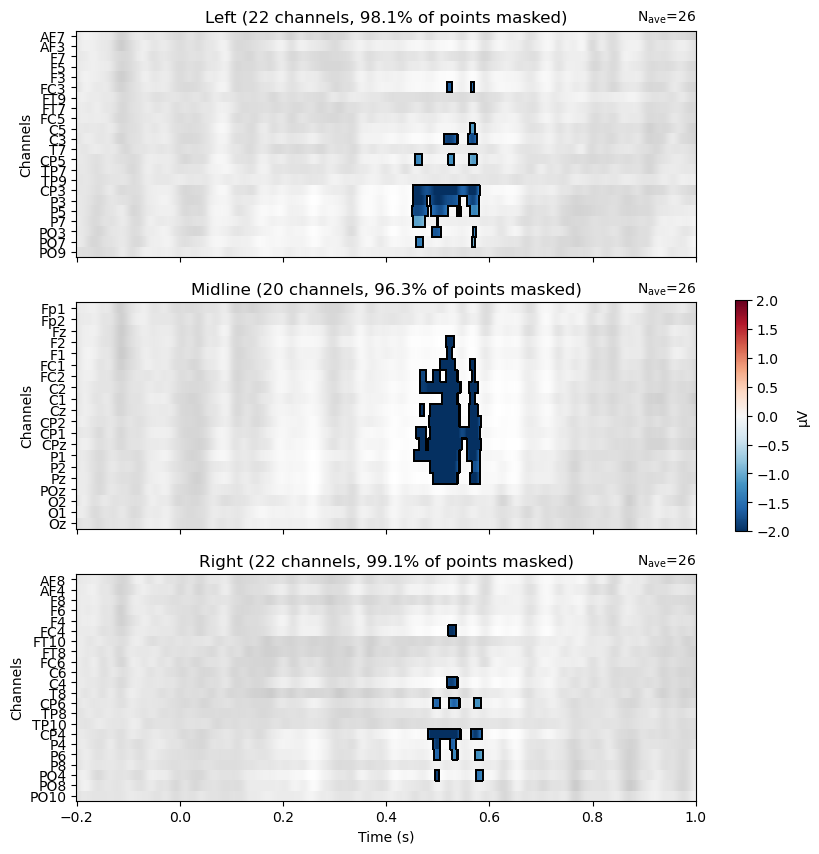

In [16]:
# stats output is time X chan, but ERP data is chan X time, so transpose
mask = cluster_pv_tfce.reshape(t_tfce.shape).T < .05

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
mne.grand_average(diff_waves).plot_image(axes=axes,
                            group_by=selections,
                            colorbar=False,
                            show=False,
                            mask=mask,
                            show_names="all",
                            titles=None,
                            **time_unit,
                            clim = dict(eeg=[-2, 2])
                            )
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()

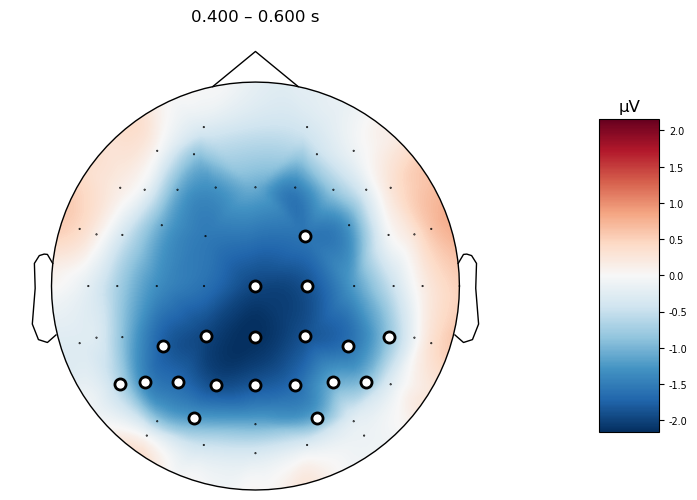

In [17]:
mne.grand_average(diff_waves).plot_topomap(times=.500,
                                             average=0.200,
                                             mask=mask,
                                             contours=False,
                                             sensors=True,
                                             size=4
                                            );

#### Interpreting TFCE Results

An important thing to understand about the difference between the clustering approach above, and TFCE, is that TFCE applies this "enhancement" operation to the entire statistical image, whereas the clustering approach only applies it to clusters that have already been identified as significant. In other words, TFCE is a data-driven approach to identifying clusters, whereas the clustering approach is a hybrid of data-driven and hypothesis-driven approaches. An important consequence of this is how TFCE results are interpreted: whereas each cluster in the conventional clustering approach above can be interpreted as a single "effect", the TFCE approach does not identify clusters, but rather identifies the entire set of channels and time points that show a significant effect. Thus when we get a result, we can only say that the effect is present across the entire set of channels and time points, and we cannot say that it is present at any particular channel or time point.

The consequences of this can be more or less impactful depending on your hypotheses and results. In the present data set we only predicted one significant effect, the N400. And indeed we only find one overall difference, which is the expected greater negativity for violation than control over channels near the vertex, roughly from 400–600 ms. Thus we can interpret the TFCE results as supporting a significant N400 effect. However, imagine if there were a second component, at a different time window and channels, that was also significant. For example, what if there was a larger *positivity* for Violation than Control over more anterior midline channels, from 800–1000 ms? (such a late positivity, or P600, is not uncommon in some N400 experiments). If our plot of TFCE results showed both the negative and positive differences — which we would attribute to two different components — we would not be able to interpret the results as supporting two components. Rather, we would only be able to say that there is a significant difference across the entire set of channels and time points. In this case, we would need to perform a follow-up analysis to determine which channels and time points are driving the effect. This could be done by performing a $t$ test at each channel and time point, and then using the clustering approach to identify significant clusters. Alternatively, if we predicted two distinct components *a priori*, then we could perform two separate TFCE analyses, each constrained to a particular time window when we expected that component, and then interpret the results as supporting two distinct components.